# Efficient Graph Based Image Segmentation (Code)

Here, we are trying to implement the algorithm proposed in [Efficient Graph-Based Image Segmentation](http://cs.brown.edu/%7Epff/segment)
which was developed by Felzenszald et al. in 2003.

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np



When the libraries are ready, we are going to open the image which will be used for the segmentation.
The image are in the dataset folder (you may find 2) the vis.jpg is a visible image, and vis_nir.jpg is an image captured with a single sensor camera (it contain visible and near infrared spectrums)

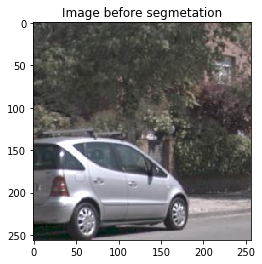

In [16]:
%matplotlib inline
img_name = 'dataset/vis.jpg'  # 'dataset/vis_nir.jpg'
img = Image.open(img_name)
img.load()
plt.title("Image before segmetation")
plt.imshow(img)
plt.draw()


According to Graph-Based Segmentation we need to make a Graph however, before such a step it is necessary to split the image channels and and make a convolution (gaussina filter), Therefore, it is necessary to define some parameters:
_kernel_
_sigma_
